In [1]:
import cv2
import matplotlib.pyplot as plt
import scipy.spatial.distance as ssd
import numpy as np
import os
from os import listdir

In [48]:
img_labels=["airplane","ball","car","cat","dolphin","face","lotus", "pickles"]

In [49]:
img_data={}
img_query={}
for label in img_labels:
    img_query[label] = [str(p) for p in Path("./").glob(label+'*')]
    img_data[label] =  [str(p) for p in Path("./database").glob(label+'*')]
img_query

{'airplane': ['airplane_query copy.jpg', 'airplane_query.jpg'],
 'ball': ['ball_query.jpg'],
 'car': ['car_query.jpg'],
 'cat': ['cat_query.jpg'],
 'dolphin': ['dolphin_query.jpg'],
 'face': ['face_query.jpg'],
 'lotus': ['lotus_query.jpg'],
 'pickles': ['pickles_querry.jpg']}

### Test Bounding Box

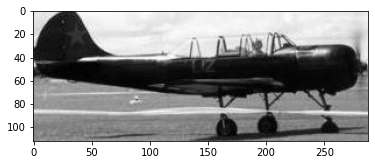

In [50]:
img1 = cv2.imread('./data_boundingBox/airplane_query.jpg')  
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
plt.imshow(gray1,cmap = plt.get_cmap('gray'))
plt.show()


In [ ]:
img_data={}
img_query={}
for label in img_labels:
    img_query[label] = [str(p) for p in Path("./data_boundingBox/").glob(label+'*')]
    img_data[label] =  [str(p) for p in Path("./data_boundingBox/database").glob(label+'*')]
img_query

### Test HOG

In [51]:
#reading image
img1 = cv2.imread('airplane_query.jpg')  
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)


Gx_img1 = cv2.Sobel(gray1,cv2.CV_64F,1,0,ksize=3)
Gy_img1 = cv2.Sobel(gray1,cv2.CV_64F,0,1,ksize=3)

'''
Gx_img1 = np.absolute(Gx_img1) * 255/np.max(Gx_img1)
plt.imshow(Gx_img1,cmap = plt.get_cmap('binary'))
plt.show()

Gy_img1 = np.absolute(Gy_img1) * 255/np.max(Gy_img1)
plt.imshow(Gy_img1,cmap = plt.get_cmap('binary'))
plt.show()
'''

"\nGx_img1 = np.absolute(Gx_img1) * 255/np.max(Gx_img1)\nplt.imshow(Gx_img1,cmap = plt.get_cmap('binary'))\nplt.show()\n\nGy_img1 = np.absolute(Gy_img1) * 255/np.max(Gy_img1)\nplt.imshow(Gy_img1,cmap = plt.get_cmap('binary'))\nplt.show()\n"

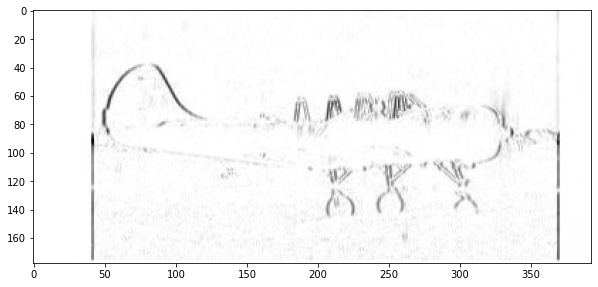

In [52]:
Gxout =  np.absolute(Gx_img1)
Gxout = Gxout * 255/np.max(Gxout)
plt.figure(figsize = (10,10))
plt.imshow(Gxout,cmap = plt.get_cmap('binary'))
plt.show()

In [53]:
ForceGradient_img1 = np.sqrt(np.power(Gx_img1,2)+np.power(Gy_img1,2))

In [54]:
ForceGradient_img1.shape

(178, 393)

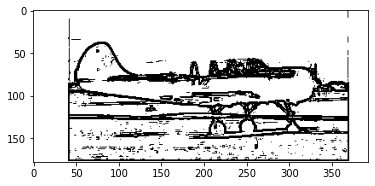

In [55]:
aretes = ForceGradient_img1>80
plt.imshow(aretes, plt.get_cmap('binary'))
plt.show()

In [56]:
FG_img1, AG_img1 = cv2.cartToPolar(Gx_img1, Gy_img1, angleInDegrees=True)

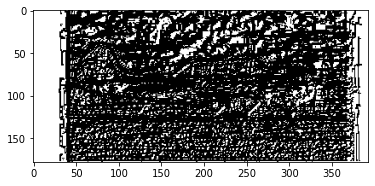

In [57]:
aretes = AG_img1>80
plt.imshow(aretes, plt.get_cmap('binary'))
plt.show()

In [58]:
np.max(FG_img1)

903.7366873155034

In [59]:
gray1.shape

(178, 393)

In [60]:
winSize = (32,32) #Taille de la fenètre de détection 
blockSize = (16,16) #taille des blocs
blockStride = (8,8) #pas pour le placement des blocs
cellSize = (4,4) #Taille de la cellule
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
winStride = (8,8)
padding = (8,8)
locations = ((10,20),)
hist = hog.compute(gray1,winStride,padding,locations)

In [61]:
max(hist)

0.51556146

In [62]:
hist.shape

(1296,)

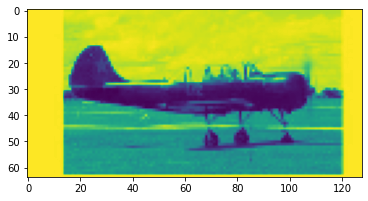

In [63]:
resize_img1=cv2.resize(img1,(128,64))
resize_gray1 = cv2.cvtColor(resize_img1, cv2.COLOR_BGR2GRAY)
plt.imshow(resize_gray1)

In [64]:
resize_gray1.shape

(64, 128)

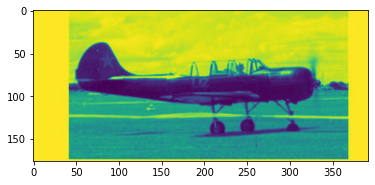

In [65]:
resize_img1=cv2.resize(img1,(img1.shape[1]//4*4,img1.shape[0]//4*4))
resize_gray1 = cv2.cvtColor(resize_img1, cv2.COLOR_BGR2GRAY)
plt.imshow(resize_gray1)

In [66]:
resize_gray1.shape

(176, 392)

In [67]:
384/16

24.0

In [68]:
winSize = (gray1.shape[1]//4*4,gray1.shape[0]//4*4)
blockSize = (8,8)
blockStride = (4,4)
cellSize = (4,4)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
winStride = (8,8)
padding = (8,8)
locations = ((10,20),)
hist = hog.compute(gray1)

In [69]:
(gray1.shape[1]//4*4,gray1.shape[0]//4*4)

(392, 176)

In [70]:
gray1.shape

(178, 393)

In [71]:
hist.shape

(150156,)

In [72]:
np.max(hist)

0.9914397

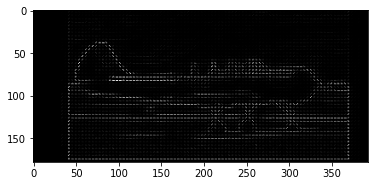

(178, 393)

In [73]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure


image = data.astronaut()

fd, hog_image = hog(img1, orientations=9, pixels_per_cell=(4, 4),
                    cells_per_block=(2, 2), visualize=True, channel_axis=-1)


#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

#ax1.axis('off')
#ax1.imshow(img1, cmap=plt.cm.gray)
#ax1.set_title('Input image')

# Rescale histogram for better display
#hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

#ax2.axis('off')
#ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
#ax2.set_title('Histogram of Oriented Gradients')
plt.imshow(hog_image, cmap=plt.cm.gray)
plt.show()
hog_image.shape

In [74]:
fd.shape

(150156,)

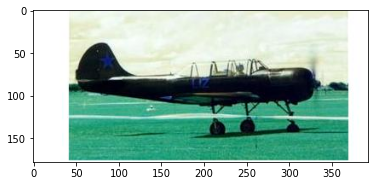

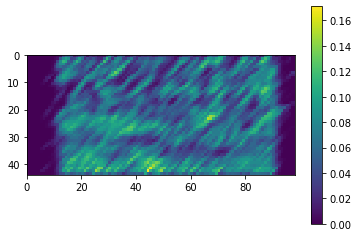

In [75]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

img = img1

cell_size = (4, 4)  # h x w in pixels
block_size = (4, 4)  # h x w in cells
nbins = 9  # number of orientation bins

# winSize is the size of the image cropped to an multiple of the cell size
hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                  img.shape[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)

n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])
hog_feats = hog.compute(img)\
               .reshape(n_cells[1] - block_size[1] + 1,
                        n_cells[0] - block_size[0] + 1,
                        block_size[0], block_size[1], nbins) \
               .transpose((1, 0, 2, 3, 4))  # index blocks by rows first
# hog_feats now contains the gradient amplitudes for each direction,
# for each cell of its group for each group. Indexing is by rows then columns.

gradients = np.zeros((n_cells[0], n_cells[1], nbins))

# count cells (border cells appear less often across overlapping groups)
cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

for off_y in range(block_size[0]):
    for off_x in range(block_size[1]):
        gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                  off_x:n_cells[1] - block_size[1] + off_x + 1] += \
            hog_feats[:, :, off_y, off_x, :]
        cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                   off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

# Average gradients
gradients /= cell_count

# Preview
plt.figure()
plt.imshow(img, cmap='gray')
plt.show()

bin = 5  # angle is 360 / nbins * direction
plt.pcolor(gradients[:, :, bin])
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
plt.show()

In [76]:
hog_feats.shape

(41, 95, 4, 4, 9)

### Application de la méthode HOG

In [77]:
sizeX=0
sizeY=0
nb_images=0
for label in img_labels:
    for path in img_data[label]:
        img = cv2.imread(path)
        sizeX+=img.shape[0]
        sizeY+=img.shape[1]
        nb_images+=1
sizeX=sizeX//nb_images
sizeY=sizeY//nb_images

In [78]:
sizeY

572

In [79]:
pictureSize = (128,128)
blockSize = (8,8)
blockStride = (4,4)
cellSize = (4,4)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64
hog = cv2.HOGDescriptor(pictureSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)

#winStride = (8,8)
#padding = (8,8)
#locations = ((10,20),)

hist = hog.compute(gray1)

In [80]:
winSize=((sizeX//cellSize[1])*cellSize[1],(sizeY//cellSize[0])*cellSize[0])
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)

In [81]:
def getDescriptor(img):
    resize_img=cv2.resize(img,(sizeX,sizeY))
    return hog.compute(resize_img)

In [82]:
query_descriptors={}
for label in img_labels:
    img = cv2.imread(img_query[label][0])  
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    query_descriptors[label]=[img_query[label][0],getDescriptor(gray)]
    
    print(img_query[label])

['airplane_query copy.jpg', 'airplane_query.jpg']
['ball_query.jpg']
['car_query.jpg']
['cat_query.jpg']
['dolphin_query.jpg']
['face_query.jpg']
['lotus_query.jpg']
['pickles_querry.jpg']


In [83]:
query_descriptors["cat"][1].shape

(797472,)

In [84]:
database_descriptors={}
for label in img_labels:
    database_descriptors[label]=[]
    for img_name in img_data[label]:
        img = cv2.imread(img_name)  
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        database_descriptors[label].append([img_name,getDescriptor(gray)])

In [85]:
top3=[("","",np.Infinity) for i in range(3)]
top3

[('', '', inf), ('', '', inf), ('', '', inf)]

In [86]:
def get_top3(label):
    top3=[("","",np.Infinity) for i in range(3)]
    top3_dist=[np.Infinity,np.Infinity,np.Infinity]
    top3_label=["","",""]
    query=query_descriptors[label]
    for l in img_labels:
        for data in database_descriptors[l]:
            d=np.linalg.norm(query[1]-data[1])
            if d<top3[2][2]:
                if d<top3[0][2]:
                    top3[2]=top3[1]
                    top3[1]=top3[0]
                    top3[0]=(data[0],l,d)
                elif d<top3[1][2]:
                    top3[2]=top3[1]
                    top3[1]=(data[0],l,d)
                else:
                    top3[2]=(data[0],l,d)
    return top3



In [87]:
top3=get_top3("lotus")

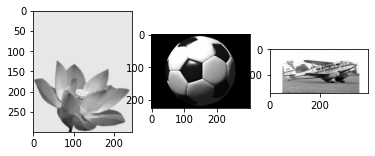

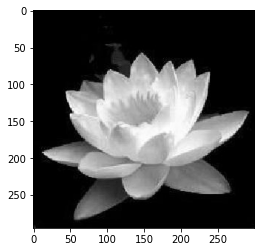

In [88]:
def showtop3(top3,query):
    f, ay = plt.subplots(1,3) 
    f, query_plot=plt.subplots(1,1) 
    for i in range(len(top3)):
        gray = cv2.cvtColor(cv2.imread(top3[i][0]), cv2.COLOR_BGR2GRAY)
        ay[i].imshow(gray,cmap="gray")
    gray = cv2.cvtColor(cv2.imread(query[0]), cv2.COLOR_BGR2GRAY)
    query_plot.imshow(gray,cmap="gray")
    plt.show()
showtop3(top3,query=query_descriptors["lotus"])

In [89]:
top3

[('database\\lotus_3.jpg', 'lotus', 125.259995),
 ('database\\ball_2.jpg', 'ball', 129.8604),
 ('database\\airplane_5.jpg', 'airplane', 134.43779)]

In [90]:
mean_positive_rate=0
for label in img_labels:
    top3=get_top3(label)
    positive_rate=0
    for i in range(len(top3)):
        if top3[i][1]==label:
            positive_rate+=1*(3-i)*0.2
    positive_rate=positive_rate/1
    mean_positive_rate+=positive_rate
mean_positive_rate=mean_positive_rate/len(img_labels)
mean_positive_rate

0.5833333333333333

### Test SIFT

23
352.1418748938519
51
77


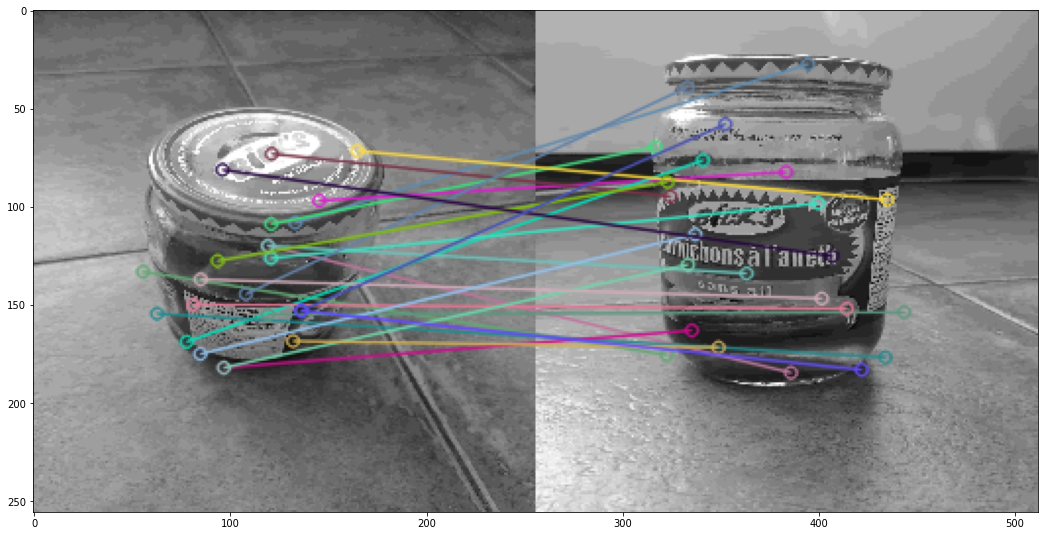

In [341]:
# voir: https://github.com/gabilodeau/INF6804/blob/master/SIFTDescriptor.ipynb
# voir: https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html

#reading image
img1 = cv2.imread('pickles_querry.jpg',cv2.IMREAD_GRAYSCALE)  
img2 = cv2.imread('database/pickles_4.jpg',cv2.IMREAD_GRAYSCALE)
img1 =cv2.resize(img1,(256,256))
img2 =cv2.resize(img2,(256,256))

#keypoints
sift = cv2.SIFT_create(nOctaveLayers = 3, contrastThreshold=0.05,edgeThreshold =15,sigma=4)
keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)


#find matches with brute force matching:
bf = cv2.BFMatcher_create(cv2.NORM_L2,crossCheck=True) #NORM_L2 prend la distance euclidienne
matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)
print(len(matches))
dist=0
for match in matches:
    dist += match.distance
print(dist/len(matches))
print(len(keypoints_1))
print(len(keypoints_2))

plt.figure(figsize = (18,10))
imageout3 = cv2.drawMatches(img1,keypoints_1,img2,keypoints_2,matches[0:30], None, flags = 2)
plt.imshow(imageout3)
plt.show()


## SIFT search in database

In [368]:
def correspond_SIFT1(descriptors_1,descriptors_2,keypoints_1,keypoints_2):
    bf = cv2.BFMatcher(cv2.NORM_L2) #NORM_L2 prend la distance euclidienne de donnée descripteurs
    matches = bf.knnMatch(descriptors_1,descriptors_2,k=2)
    bonMatch = []
    # méthode du ratio: 
    for m,n in matches:
        if m.distance < 0.5*n.distance:
            bonMatch.append([m])
            break
    number_keypoints = 0
    if len(keypoints_1) <= len(keypoints_2):
        number_keypoints = len(keypoints_1)
    else:
        number_keypoints = len(keypoints_2)
    indice = len(bonMatch)/number_keypoints * 100
    return indice

def correspond_SIFT2(descriptors_1,descriptors_2,keypoints_1,keypoints_2):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True) #NORM_L2 prend la distance euclidienne de donnée descripteurs
    matches = bf.match(descriptors_1,descriptors_2)
    dist=0
    for match in matches:
        dist += match.distance
    return dist/len(matches)

def search_database(query):
    im_query = cv2.imread(query,cv2.IMREAD_GRAYSCALE)
    im_query =cv2.resize(im_query,(256,256))

    sift = cv2.SIFT_create(nOctaveLayers = 3, contrastThreshold=0.03,edgeThreshold =15,sigma=4)
    keypoints_1, descriptors_1 = sift.detectAndCompute(im_query,None)
    result = {}
    for images in os.listdir("./database/"):
        database = cv2.imread("./database/"+images,cv2.IMREAD_GRAYSCALE)
        database = cv2.resize(database,(256,256))

        keypoints_2, descriptors_2 = sift.detectAndCompute(database,None)
        #find matches with brute force matching:
        score = correspond_SIFT2(descriptors_1,descriptors_2,keypoints_1,keypoints_2)
        result[score] = images
    myKeys = list(result.keys())
    myKeys.sort()
    sorted_dict = {i: result[i] for i in myKeys}
    print(sorted_dict)


In [377]:
search_database("airplane_query.jpg")

{293.44782165527346: 'dolphin_2.jpg', 297.0149090415553: 'dolphin_4.jpg', 303.94752135100185: 'airplane_1.jpg', 304.2713020726254: 'ball_2.jpg', 306.728680840854: 'airplane_4.jpg', 307.9615430831909: 'ball_3.jpg', 313.4828002566383: 'airplane_2.jpg', 320.9977996826172: 'ball_5.jpg', 324.49426523844403: 'face_3.jpg', 327.69822216033936: 'dolphin_3.jpg', 330.0409469604492: 'airplane_3.jpg', 331.3031212059227: 'face_1.jpg', 332.98542868124474: 'dolphin_5.jpg', 333.0467185974121: 'pickles_4.jpg', 333.17358350753784: 'face_5.jpg', 333.3083862304687: 'lotus_3.jpg', 335.1225959514749: 'face_4.jpg', 336.3787967847741: 'lotus_5.jpg', 336.8059659211532: 'pickles_1.jpg', 337.02598928897936: 'cat_1.jpg', 338.37826650282915: 'airplane_5.jpg', 338.86004873422473: 'ball_1.jpg', 341.5098313122261: 'lotus_1.jpg', 342.05736146149815: 'pickles_5.jpg', 342.1678779602051: 'cat_5.jpg', 342.55570242745534: 'car_1.jpg', 342.9296864827474: 'car_2.jpg', 343.6169981345152: 'car_5.jpg', 346.6373772872122: 'ball_4

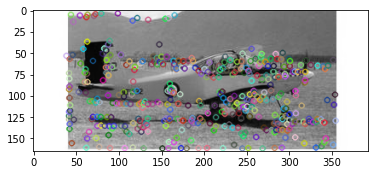

In [351]:
#reading image
img2 = cv2.imread('./database/airplane_1.jpg')  
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#keypoints
sift = cv2.xfeatures2d.SIFT_create(	nOctaveLayers = 3, contrastThreshold=0.04,edgeThreshold = 10,sigma=1.6)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

img_2 = cv2.drawKeypoints(gray2,keypoints_2,img2)
plt.imshow(img_2)
plt.show()


In [ ]:
descriptors_1.shape

: 

In [ ]:
descriptors_2.shape

: 

### Fonction correspondance d'image pour SIFT

In [248]:
def correspond(descriptors_1,descriptors_2,keypoints_1,keypoints_2):
    bf = cv2.BFMatcher_create(cv2.NORM_L2) #NORM_L2 prend la distance euclidienne
    matches = bf.knnMatch(descriptors_1,descriptors_2,k=2)
    bonMatch = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            bonMatch.append([m])
    number_keypoints = 0
    if len(keypoints_1) <= len(keypoints_2):
        number_keypoints = len(keypoints_1)
    else:
        number_keypoints = len(keypoints_2)
    print("matches:")
    print(len(matches))
    print("number_keypoint")
    print([len(keypoints_1), len(keypoints_2), number_keypoints])

    print("bon_point")
    print(len(bonMatch))
    indice = len(bonMatch)/number_keypoints * 100
    return indice

: 